# Rotation map creation
Valentin Dall'Alba / January 2020

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

exec(open('./functions/rotation_map_creation_function.py').read())

## 1 : Load data
We load the data points set which is composed of rotation points, described by their coordinnates and their rotation values.  


In [87]:
pathIn  = './data/rotationPointsSet.csv'

In [5]:
rotationPoints =pd.read_csv(pathIn,delimiter=',')
rotationPoints.head()

,angle,x,y
0,-85,682933.9653,6153956.956
1,-85,683111.9512,6155444.584
2,0,679636.7270,6157843.244
3,0,681672.2813,6161050.361
4,-20,679848.6802,6164184.264


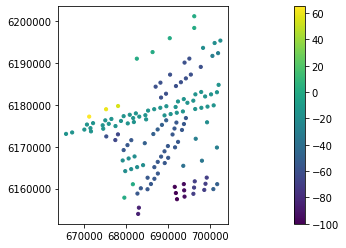

In [7]:
plt.scatter(rotationPoints['x'],rotationPoints['y'],s=10,c=rotationPoints['angle'])
plt.colorbar()
plt.axis('scaled')
plt.show()

## 2 : Variogram interpretation
We are going to krige the rotation data points set in order to create the rotation maps.

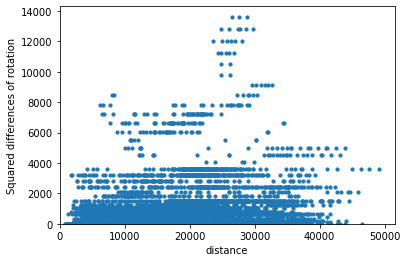

In [14]:
#variogram cloud
hc, gc = cloud(rotationPoints['x'],rotationPoints['y'],rotationPoints['angle'])
plt.scatter(hc, gc, s=10)
plt.xlabel('distance')
plt.ylabel('Squared differences of rotation')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

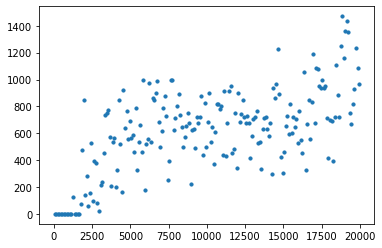

In [11]:
 #experimental variogram
he, ge = experimental(hc, gc, 100, 200)
plt.scatter(he, ge, s=10)
plt.show()

In [37]:
#define the parameter of the model
lag  = 100
nlag = 200
x    = np.linspace(0, nlag * lag, 1000)
sillE  = 850
rangeE = 8000
y      = spherical(x, sillE, rangeE) #we want a smooth interpolation and thus dot not define a nugget effect to the model

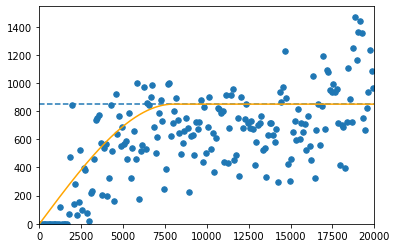

In [38]:
#adjust the model
plt.scatter(he, ge, s=30)
variance = np.var(rotationPoints['angle'])
plt.axhline(variance, linestyle='--')
plt.xlim(xmin=0, xmax=lag * nlag)
plt.ylim(ymin=0)
plt.title('')
plt.plot(x, y,color='orange')
plt.show()

## 3 : Kriging

In [30]:
#Those modules are parts of the Geone packages
import geone.covModel as gcm
import geone.customcolors as ccol
from geone import grf

In [83]:
#define the model
cov_model = gcm.CovModel2D(elem=[
    ('spherical', {'w':850., 'r':[8000]}), # elementary contribution
                       ], alpha=0, name='model-2D test')

In [84]:
cov_fun   = cov_model.func()
vario_fun = cov_model.vario_func()

In [44]:
#create the grid
nx, ny = 409, 512  # number of cells
dx, dy = 100, 100  # cell unit
ox, oy = 664328.1865, 6153000.2413  # origin

dimension = [nx, ny]
spacing   = [dx, dy]
origin    = [ox, oy]

In [45]:
extensionMin = [grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxy(), dimension, spacing)]

In [46]:
X = np.array([[x,y] for x,y in zip(rotationPoints['x'],rotationPoints['y'])])

In [47]:
Y = np.array(rotationPoints['angle'])

In [48]:
krig2Db, krig2Db_std = grf.krige2D(X, Y, cov_fun, dimension, spacing, origin, 
                                   extensionMin=extensionMin)

KRIGE2D: Computing circulant embedding...
KRIGE2D: Embedding dimension: 512 x 1024
KRIGE2D: Computing FFT of circulant matrix...
KRIGE2D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE2D: Computing index in the embedding grid for non-conditioning / conditioning locations...
KRIGE2D: computing kriging estimates...
KRIGE2D: computing kriging standard deviation ...


In [86]:
#The DeeSse algorithm can work with a tolerance on the rotation values. We create a 20° of tolerance for the rotation.
kMin = krig2Db-10
kMax = krig2Db+10

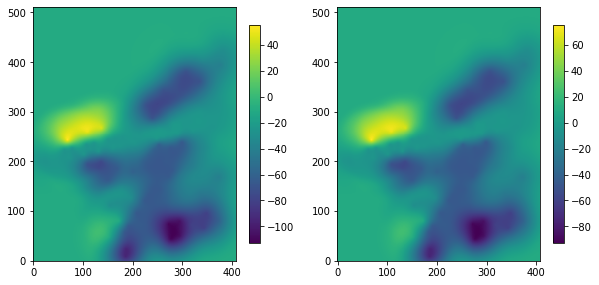

In [59]:
plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(kMin.reshape((512,409)),origin='lower')
plt.colorbar(shrink=0.4)
plt.subplot(1,2,2)
plt.imshow(kMax.reshape((512,409)),origin='lower')
plt.colorbar(shrink=0.4)

## 4 : 3D rotation map 
We use the 3D mask to cut the kriging map in the shape of the simulation grid and store the 2 rotation variables in a Geone Img.

In [60]:
from geone import img
from geone import imgplot

In [65]:
rotationVal = np.ones((2,1,ny,nx))*-1
rotationVal[0,0,:,:] = kMin
rotationVal[1,0,:,:] = kMax

In [66]:
#We load the 3D mask
pathMask= '/home/valentin/ownCloud/00_Institution/03_Code_Python/3.0/99_Data/roussillon/grid_mask/grid3D_RGF.pickle'
with open(pathMask,'rb') as file:
    mask = pickle.load(file)

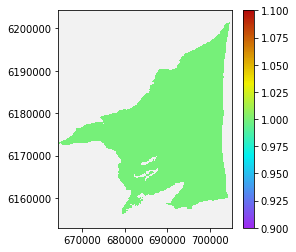

In [62]:
valMask = mask.val[1,:125,:,:]
imgplot.drawImage2D(mask,iv=1,vmin=1,vmax=1)

In [68]:
#Create the empty 3D rotation map
rotationVal3D = np.full((2,125,512,409),np.nan)
rotationVal3D.shape

(2, 125, 512, 409)

In [80]:
for z in range(125):
    rotationVal3D[0,z][mask.val[1,z]==1] =rotationVal[0,0][mask.val[1,z]==1] 

In [81]:
rotationImg = img.Img(nx=nx, ny=ny, nz=125,
                     sx=100, sy=100, sz=2,
                     ox=ox, oy=oy, oz=-250, nv=2,val=rotationVal3D)

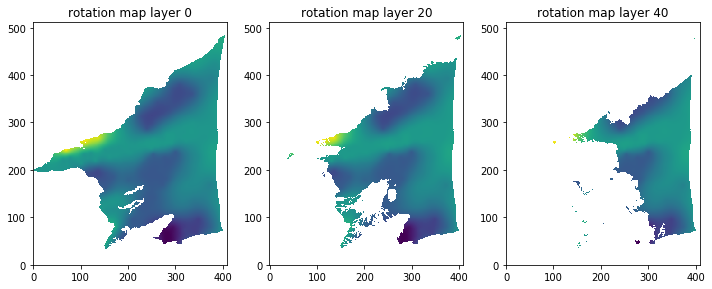

In [82]:
plt.subplots(1,3,figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(rotationImg.val[0,0],origin='lower')
plt.title('rotation map layer 0')
plt.subplot(1,3,2)
plt.imshow(rotationImg.val[0,20],origin='lower')
plt.title('rotation map layer 20')
plt.subplot(1,3,3)
plt.imshow(rotationImg.val[0,40],origin='lower')
plt.title('rotation map layer 40')
plt.tight_layout()
plt.show()